In [11]:
using Turing, StatsPlots, DifferentialEquations, LinearAlgebra

In [12]:
# Define the parameters
true_D = 0.25

# Temporal domain
n_time_points = 6
tspan = (0, 0.3)
t_domain = range(tspan[1], stop=tspan[2], length=n_time_points)

# Spatial domain
n_space_points = 21
x_domain = range(0, stop=1, length=n_space_points)
dx = x_domain[2] - x_domain[1]

# Define the initial condition
u0 = exp.(-20 *(x_domain .- 0.5).^2);

In [13]:
# Define the discretized DE using finite difference method
function discretized_diffusion!(du, u, p, t)
    D = p[1] # diffusivity # p is an array of parameters
    for i in 2:(n_space_points - 1)
        du[i] = D * (u[i+1] - 2 * u[i] + u[i-1]) / dx^2;
    end
    du[1] = du[n_space_points] = 0 # Zero-flux boundary conditions
end

discretized_diffusion! (generic function with 1 method)

In [14]:
# Solve the discretized PDE to obtain true states
p_true = [true_D]
true_problem = ODEProblem(discretized_diffusion!, u0, tspan, p_true)
true_solution = solve(true_problem, Tsit5(), saveat=t_domain)

retcode: Success
Interpolation: 1st order linear
t: 6-element Vector{Float64}:
 0.0
 0.06
 0.12
 0.18
 0.24
 0.3
u: 6-element Vector{Vector{Float64}}:
 [0.006737946999085467, 0.017422374639493497, 0.04076220397836619, 0.08629358649937054, 0.16529888822158656, 0.2865047968601901, 0.4493289641172215, 0.6376281516217733, 0.8187307530779818, 0.951229424500714  …  0.951229424500714, 0.8187307530779818, 0.6376281516217733, 0.4493289641172215, 0.2865047968601901, 0.16529888822158656, 0.08629358649937054, 0.04076220397836619, 0.017422374639493497, 0.006737946999085467]
 [0.006737946999085467, 0.06854322833129357, 0.13466312893786525, 0.20821036336727194, 0.28997362886610506, 0.37788200741963146, 0.46679137651152136, 0.5492322720190937, 0.616568808991424, 0.6607986037868511  …  0.6607986037868507, 0.6165688089914249, 0.5492322720190925, 0.4667913765115225, 0.37788200741963035, 0.28997362886610634, 0.2082103633672708, 0.13466312893786625, 0.06854322833129313, 0.006737946999085467]
 [0.0067379469

In [15]:
# Generate noisy observations
noise_std = 0.1
noisy_data = true_solution .+ randn(n_space_points,n_time_points) * noise_std;

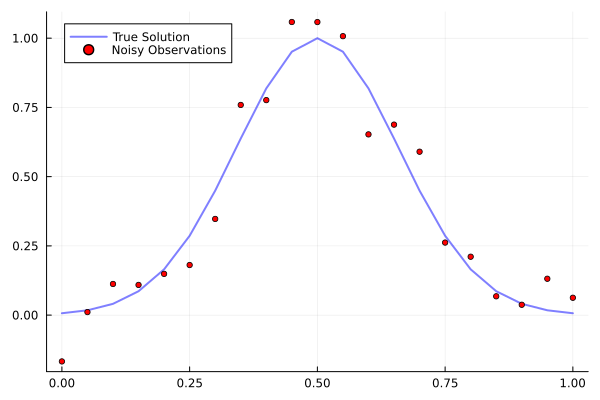

In [16]:
# Plot the true solution and noisy observations
p = plot(x_domain, true_solution[:, 1], label="True Solution", lw=2, color=:blue, alpha=0.5)
scatter!(x_domain, noisy_data[:, 1], label="Noisy Observations", color=:red, legend=:topleft, markersize=3)

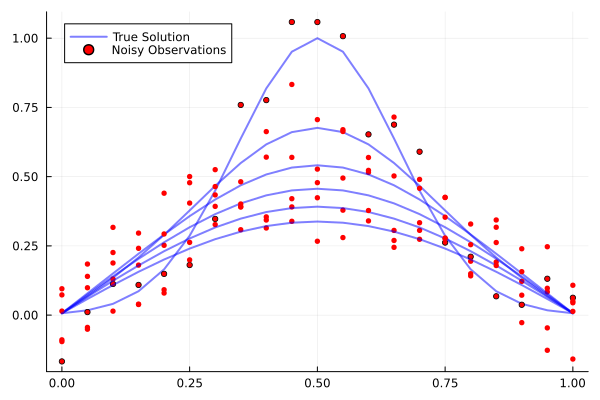

In [17]:
for i in 2:n_time_points
    plot!(x_domain, true_solution[:, i], lw=2, label="", color=:blue, alpha=0.5)
    scatter!(x_domain, noisy_data[:, i], color=:red, label="", markersize=3, markerstrokewidth=0)
end 
p

In [18]:
@model function fit_diffusion(observed_data, t_domain)

    # Define the prior distribution for the diffusion coefficient
    D ~ Beta(2, 3)
    ### try different priors for your mini project

    # And the prior distribution for the noise
    σ ~ InverseGamma(10, 3)
    ### try different priors for your mini project


    # Solve the discretized PDE with the current parameter value
    param = [ D ]
    problem = ODEProblem(discretized_diffusion!, u0, tspan, param)
    prediction = solve(problem, Tsit5(), saveat=t_domain)

    # Define the likelihood for the observed data    #observed_data ~ arraydist(Normal.(prediction, σ))
    for i in 1:length(prediction)
        observed_data[:, i] ~ MvNormal(prediction[i], σ^2*I)
    end
    
end

fit_diffusion (generic function with 2 methods)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/stju/.julia/packages/Turing/0yJdp/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:04:25
Sampling   1%|▍                                         |  ETA: 0:02:26
Sampling   1%|▋                                         |  ETA: 0:01:42
Sampling   2%|▊                                         |  ETA: 0:01:20
Sampling   2%|█                                         |  ETA: 0:01:06
Sampling   3%|█▏                                        |  ETA: 0:00:58
Sampling   3%|█▍                                        |  ETA: 0:00:51
Sampling   4%|█▋                                        |  ETA: 0:00:46
Sampling   4%|█▊                                        |  ETA: 0:00:42
Sampling   5%|██                                        |  ETA: 0:00:40
Sampling   5%|██▏                                       |  ETA: 0:00:37
Sampling   6%|

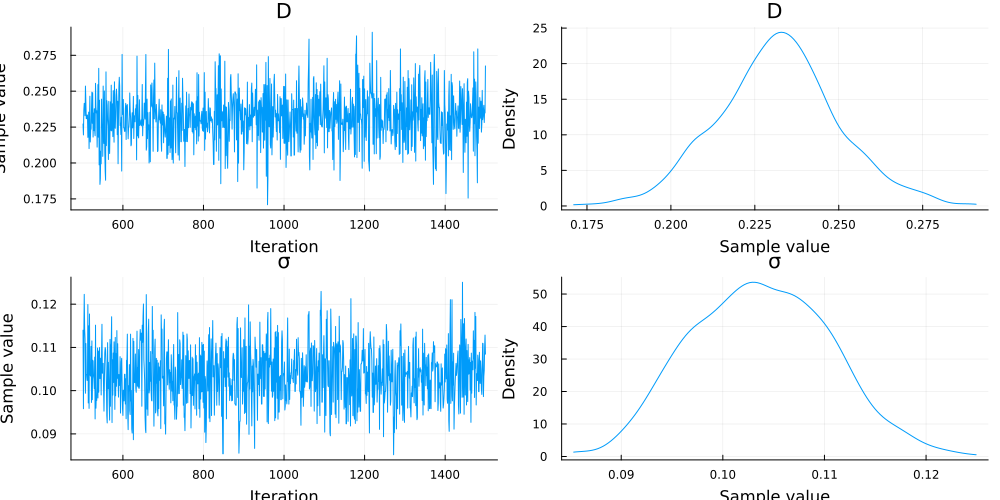

In [19]:
# Run the sampler
model = fit_diffusion(noisy_data, t_domain)
chain = sample(model, NUTS(), 1000)
plot(chain)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.8
└ @ Turing.Inference /Users/stju/.julia/packages/Turing/0yJdp/src/mcmc/hmc.jl:191
Sampling   0%|▎                                         |  ETA: 0:02:44
Sampling   1%|▍                                         |  ETA: 0:01:36
Sampling   1%|▋                                         |  ETA: 0:01:16
Sampling   2%|▊                                         |  ETA: 0:01:02
Sampling   2%|█                                         |  ETA: 0:00:57
Sampling   3%|█▏                                        |  ETA: 0:00:52
Sampling   3%|█▍                                        |  ETA: 0:00:49
Sampling   4%|█▋                                        |  ETA: 0:00:46
Sampling   4%|█▊                                        |  ETA: 0:00:42
Sampling   5%|██                                        |  ETA: 0:00:41
Sampling   5%|██▏                                       |  ETA: 0:00:39
Sampling   6%|

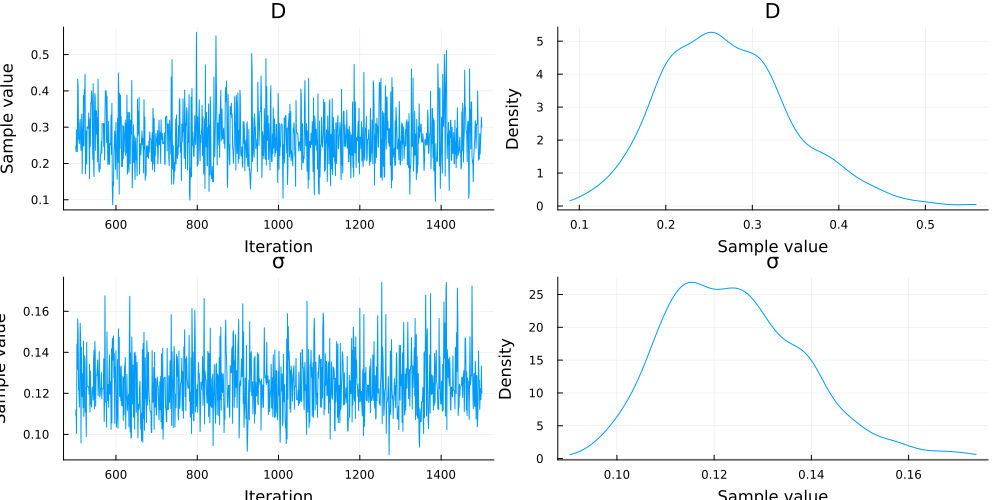

In [20]:
# what if we observe only the first time step
model_short = fit_diffusion(noisy_data[:,1:2], t_domain[1:2])
chain_short = sample(model_short, NUTS(), 1000)
plot(chain_short)